<a href="https://colab.research.google.com/github/Alba251/face_detection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Alba251/face_detection.git
%cd face_detection


Cloning into 'face_detection'...
remote: Enumerating objects: 5034, done.
remote: Counting objects: 100% (5034/5034), done.
remote: Compressing objects: 100% (5032/5032), done.
remote: Total 5034 (delta 16), reused 5003 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (5034/5034), 33.39 MiB | 7.26 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Updating files: 100% (5003/5003), done.
/content/face_detection


In [10]:
#LIBRERIAS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tqdm import tqdm


In [3]:
data = pd.read_csv("./data/data.csv", sep=';', dtype={'gender': str})
data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,male,70,111,107,111,37
1,1.jpg,male,71,110,106,111,31
2,2.jpg,male,71,111,106,110,37
3,3.jpg,male,68,111,108,112,51
4,4.jpg,male,71,111,106,110,36


In [ ]:
print(data.describe(include = "all"))

         im_name  gender  left_eye_x  left_eye_y  right_eye_x  right_eye_y  \
count       5000    5000  5000.00000  5000.00000   5000.00000  5000.000000   
unique      5000       2         NaN         NaN          NaN          NaN   
top     4999.jpg  female         NaN         NaN          NaN          NaN   
freq           1    2884         NaN         NaN          NaN          NaN   
mean         NaN     NaN    69.39320   111.18780    107.60540   111.144200   
std          NaN     NaN     1.73931     1.12338      1.70689     1.179866   
min          NaN     NaN    60.00000   104.00000     93.00000   100.000000   
25%          NaN     NaN    68.00000   111.00000    107.00000   111.000000   
50%          NaN     NaN    69.00000   111.00000    108.00000   111.000000   
75%          NaN     NaN    70.00000   112.00000    109.00000   112.000000   
max          NaN     NaN    86.00000   117.00000    114.00000   122.000000   

                age  
count   5000.000000  
unique          NaN

In [4]:
#Conertimos la columan de male, female a binario

data['gender'] = data['gender'].map({'male':1, 'female':0})
data.head()


,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,70,111,107,111,37
1,1.jpg,1,71,110,106,111,31
2,2.jpg,1,71,111,106,110,37
3,3.jpg,1,68,111,108,112,51
4,4.jpg,1,71,111,106,110,36


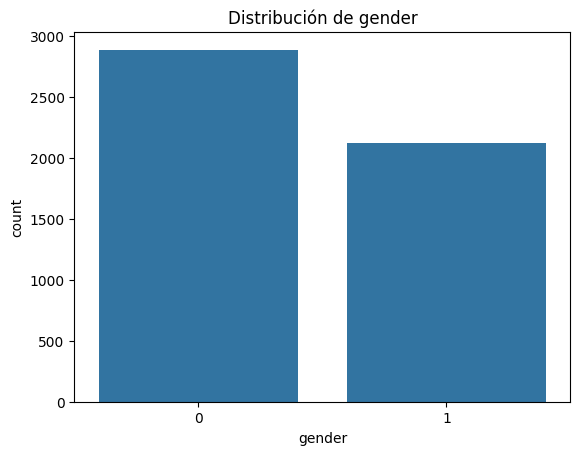

In [ ]:
 #Ahora analizaremos cada variable
sns.countplot(x='gender', data=data)
plt.title("Distribución de gender")
plt.show()

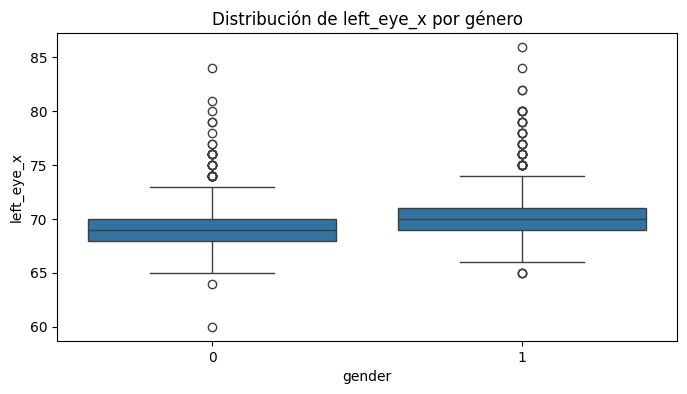

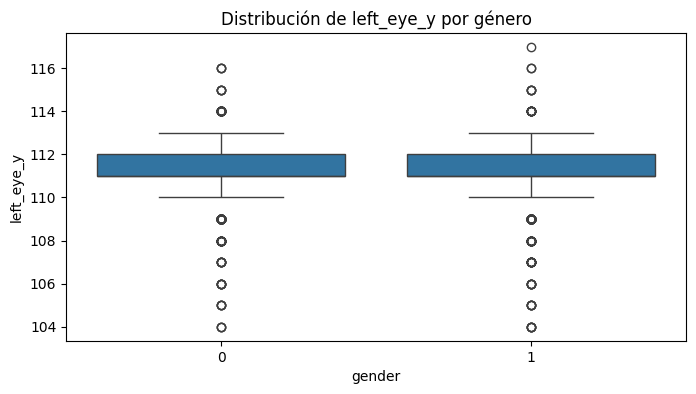

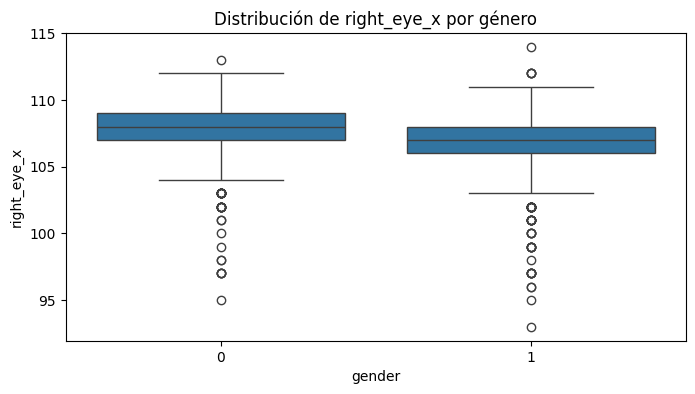

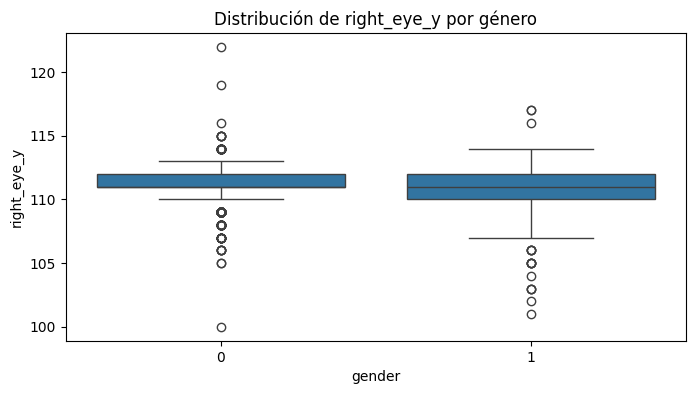

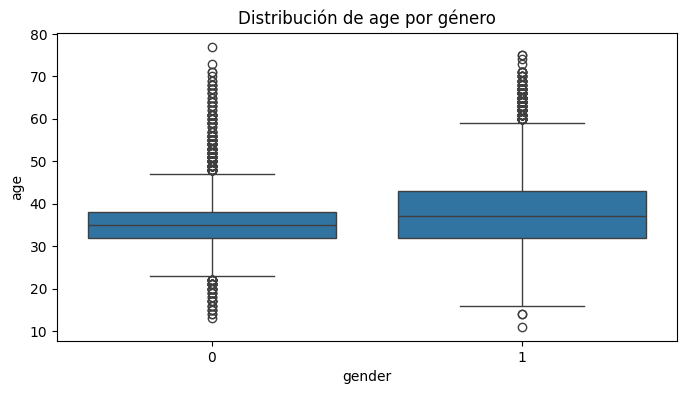

In [ ]:
numerical_cols = ['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'age']

for col in numerical_cols:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='gender', y=col, data=data)
    plt.title(f'Distribución de {col} por género')
    plt.show()

#Tenemos resultados muy diferentes, lo que tiene sentido pq la persona puede estar desplazada...

In [5]:
#Vamos a normalizar los datos de la posicon de los ojos para poder redimensionalizar las imagenes a 224x224

data['left_eye_x'] = data['left_eye_x'] / 178.0
data['right_eye_x'] = data['right_eye_x'] / 178.0
data['left_eye_y'] = data['left_eye_y'] / 218.0
data['right_eye_y'] = data['right_eye_y'] / 218.0
data['age'] = data['age'] / 100.0  # suponiendo que la mayoría no pasa de 100 años, consideramos este valor como máximo posible de edad, dado que un valor mayor generaria un data[age] y la sigmoide no puede dar una posible edad mayor de 1, que son 100


data.head()

,im_name,gender,left_eye_x,left_eye_y,right_eye_x,right_eye_y,age
0,0.jpg,1,0.393258,0.509174,0.601124,0.509174,0.37
1,1.jpg,1,0.398876,0.504587,0.595506,0.509174,0.31
2,2.jpg,1,0.398876,0.509174,0.595506,0.504587,0.37
3,3.jpg,1,0.382022,0.509174,0.606742,0.513761,0.51
4,4.jpg,1,0.398876,0.509174,0.595506,0.504587,0.36


In [6]:
#DIVIDIMOS EL DATASET EN TRAIN, TEST, VALIDATE

# Paso 1: dividir primero en train + temp (val+test)
images_train, images_temp, genders_train, genders_temp, ages_train, ages_temp, eyes_train, eyes_temp = train_test_split(
    data['im_name'],
    data['gender'],
    data['age'],
    data[['left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y']],
    test_size=0.3,
    stratify=data['gender'],
    random_state=42
)

# Paso 2: dividir temp en val y test (mitad y mitad)
images_val, images_test, genders_val, genders_test, ages_val, ages_test, eyes_val, eyes_test = train_test_split(
    images_temp,
    genders_temp,
    ages_temp,
    eyes_temp,
    test_size=0.5,
    stratify=genders_temp,
    random_state=42
)


In [7]:
#VAMOS A VER SI LAS CLASES ESTÁN BALANCEADAS EN CUANTO A GENERO
print(genders_train.value_counts(normalize=True))
print(genders_val.value_counts(normalize=True))
print(genders_test.value_counts(normalize=True))

gender
0    0.576857
1    0.423143
Name: proportion, dtype: float64
gender
0    0.576
1    0.424
Name: proportion, dtype: float64
gender
0    0.577333
1    0.422667
Name: proportion, dtype: float64


In [8]:
#Entrenamos el modelo con los datos recibidos a ver que tal los resultados

# Cargar imagen
def load_and_preprocess_image(filename):
    img_path = os.path.join("data/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [224, 224])
    return image

# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes, is_train=True):
    for i in range(len(images)):
        if is_train:
            img = load_and_preprocess_image(images.iloc[i])
        else:
            img = load_and_preprocess_image(images.iloc[i])
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels


def create_tf_dataset(images, genders, ages, eyes, is_train=True):
    return tf.data.Dataset.from_generator(
        lambda: tf_data_generator(images, genders, ages, eyes, is_train),
        output_signature=(
            tf.TensorSpec(shape=(224, 224, 3), dtype=tf.float32),
            {
                'gender': tf.TensorSpec(shape=(), dtype=tf.float32),
                'age': tf.TensorSpec(shape=(), dtype=tf.float32),
                'eye_pos': tf.TensorSpec(shape=(4,), dtype=tf.float32),
            }
        )
    )

train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train, is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO
#  Batch: agrupa las imagenes en lotes de 32 imagenes para que en cada iteracion entrene con 32 imagenes de golpe
#  Prefetch: mientras el modelo entrena con un lote va preparando el siguiente lote

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image



In [20]:
# ESPECIFICACIONES DEL MODELO

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-20-f1033adaad0e>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [ ]:
#ENTRENAMOS EL MODELO

####SEMILLLAAAAA


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/20
110/156 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - age_loss: 0.2376 - age_mae: 0.3193 - eye_pos_loss: 0.1595 - eye_pos_mae: 0.2535 - gender_accuracy: 0.8591 - gender_loss: 0.3149 - loss: 0.7120

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 101s 289ms/step - age_loss: 0.1932 - age_mae: 0.2766 - eye_pos_loss: 0.1286 - eye_pos_mae: 0.2206 - gender_accuracy: 0.8735 - gender_loss: 0.2883 - loss: 0.6096 - val_age_loss: 3.1627 - val_age_mae: 1.5774 - val_eye_pos_loss: 11.8963 - val_eye_pos_mae: 3.2184 - val_gender_accuracy: 0.5842 - val_gender_loss: 7.9983 - val_loss: 23.0573
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 146ms/step - age_loss: 0.0096 - age_mae: 0.0773 - eye_pos_loss: 0.0054 - eye_pos_mae: 0.0576 - gender_accuracy: 0.9631 - gender_loss: 0.1004 - loss: 0.1152 - val_age_loss: 0.5031 - val_age_mae: 0.6069 - val_eye_pos_loss: 8.9214 - val_eye_pos_mae: 2.7191 - val_gender_accuracy: 0.6834 - val_gender_loss: 3.9836 - val_loss: 13.4081
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - age_loss: 0.0078 - age_mae: 0.0692 - eye_pos_loss: 0.0035 - eye_pos_mae: 0.0467 - gender_accuracy: 0.9795 - gender_loss: 0.0571 - loss: 0.0684 - val_age_loss: 0.2538 - val_age_mae: 0.4129 - val_eye_pos_lo

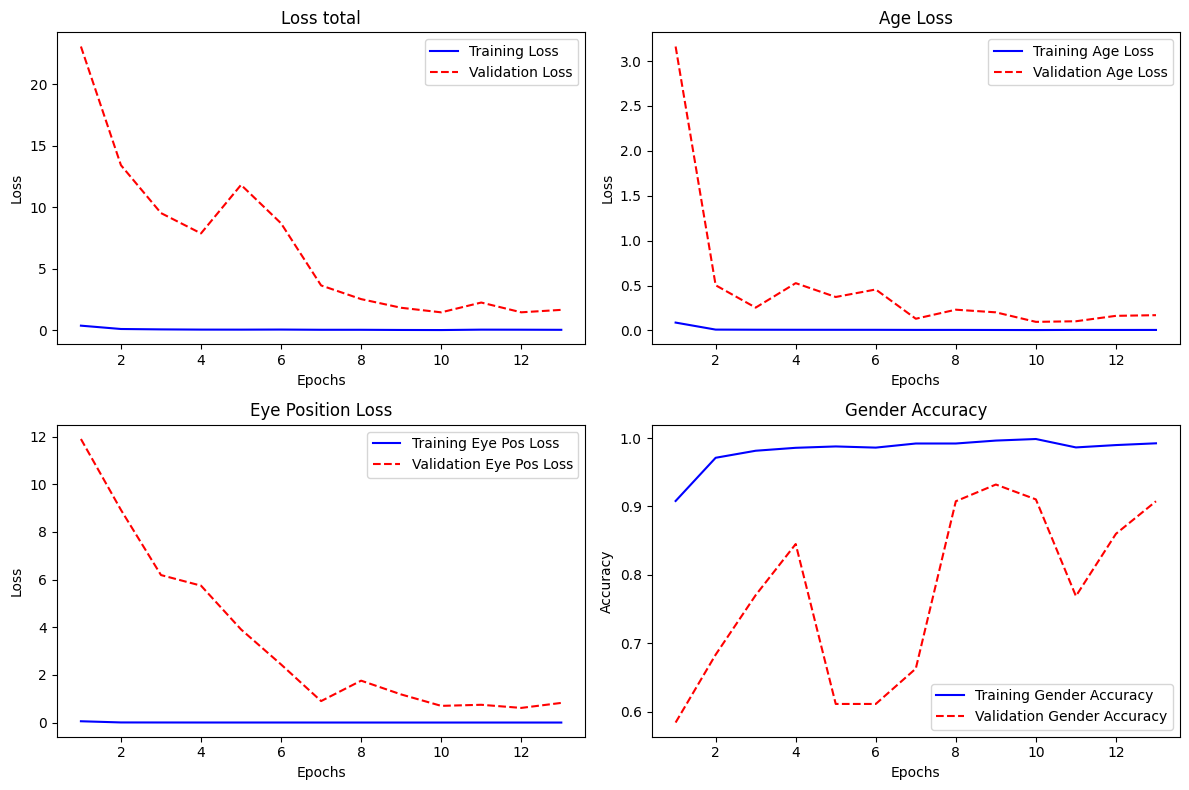

In [ ]:
def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)

    # Plot loss total vs val_loss
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 2, 1)
    plt.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], 'r--', label='Validation Loss')
    plt.title('Loss total')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot age_loss vs val_age_loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, history.history['age_loss'], 'b-', label='Training Age Loss')
    plt.plot(epochs, history.history['val_age_loss'], 'r--', label='Validation Age Loss')
    plt.title('Age Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot eye_pos_loss vs val_eye_pos_loss
    plt.subplot(2, 2, 3)
    plt.plot(epochs, history.history['eye_pos_loss'], 'b-', label='Training Eye Pos Loss')
    plt.plot(epochs, history.history['val_eye_pos_loss'], 'r--', label='Validation Eye Pos Loss')
    plt.title('Eye Position Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot gender_accuracy vs val_gender_accuracy
    plt.subplot(2, 2, 4)
    plt.plot(epochs, history.history['gender_accuracy'], 'b-', label='Training Gender Accuracy')
    plt.plot(epochs, history.history['val_gender_accuracy'], 'r--', label='Validation Gender Accuracy')
    plt.title('Gender Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Llamar a la función con tu objeto history
plot_training_history(history)

In [16]:

# Backbone CNN preentrenada
base_model = EfficientNetB0(include_top=False, input_tensor=input_img, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)



Epoch 1/20
110/156 ━━━━━━━━━━━━━━━━━━━━ 23s 505ms/step - age_loss: 0.0887 - age_mae: 0.2173 - eye_pos_loss: 0.0755 - eye_pos_mae: 0.1940 - gender_accuracy: 0.8630 - gender_loss: 0.3042 - loss: 0.4684

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 144s 424ms/step - age_loss: 0.0748 - age_mae: 0.1962 - eye_pos_loss: 0.0627 - eye_pos_mae: 0.1728 - gender_accuracy: 0.8756 - gender_loss: 0.2799 - loss: 0.4169 - val_age_loss: 0.0076 - val_age_mae: 0.0628 - val_eye_pos_loss: 0.1206 - val_eye_pos_mae: 0.2182 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.0597 - val_loss: 1.1880
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - age_loss: 0.0095 - age_mae: 0.0768 - eye_pos_loss: 0.0046 - eye_pos_mae: 0.0538 - gender_accuracy: 0.9641 - gender_loss: 0.1013 - loss: 0.1154 - val_age_loss: 0.0346 - val_age_mae: 0.1652 - val_eye_pos_loss: 0.0204 - val_eye_pos_mae: 0.1161 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.3451 - val_loss: 1.4001
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 24s 155ms/step - age_loss: 0.0079 - age_mae: 0.0705 - eye_pos_loss: 0.0027 - eye_pos_mae: 0.0415 - gender_accuracy: 0.9825 - gender_loss: 0.0444 - loss: 0.0552 - val_age_loss: 0.0165 - val_age_mae: 0.1003 - val_eye_pos_loss:

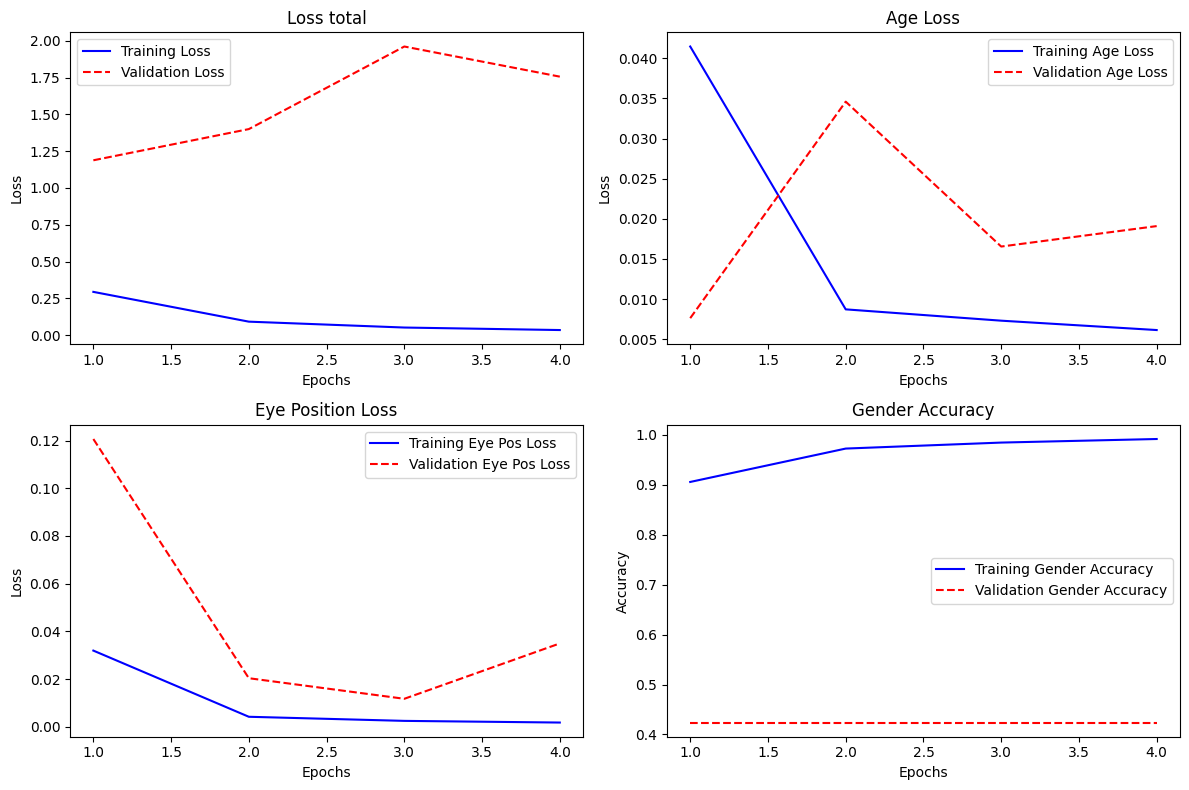

In [17]:
# Presentar grafica de metricas
plot_training_history(history)

In [18]:

# Backbone CNN preentrenada
base_model = ResNet50(include_top=False, input_tensor=input_img, weights='imagenet')

x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
gender_output = Dense(1, activation='sigmoid', name='gender')(x)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
110/156 ━━━━━━━━━━━━━━━━━━━━ 27s 587ms/step - age_loss: 1.6605 - age_mae: 0.6459 - eye_pos_loss: 0.1684 - eye_pos_mae: 0.2496 - gender_accuracy: 0.7707 - gender_loss: 0.4615 - loss: 2.2905

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


156/156 ━━━━━━━━━━━━━━━━━━━━ 146s 502ms/step - age_loss: 1.3231 - age_mae: 0.5409 - eye_pos_loss: 0.1346 - eye_pos_mae: 0.2148 - gender_accuracy: 0.7917 - gender_loss: 0.4277 - loss: 1.8859 - val_age_loss: 0.0088 - val_age_mae: 0.0622 - val_eye_pos_loss: 0.1033 - val_eye_pos_mae: 0.2997 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.9556 - val_loss: 1.0677
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 49s 312ms/step - age_loss: 0.0172 - age_mae: 0.1036 - eye_pos_loss: 0.0044 - eye_pos_mae: 0.0528 - gender_accuracy: 0.9311 - gender_loss: 0.1649 - loss: 0.1867 - val_age_loss: 0.0240 - val_age_mae: 0.1309 - val_eye_pos_loss: 0.0051 - val_eye_pos_mae: 0.0519 - val_gender_accuracy: 0.4239 - val_gender_loss: 0.9515 - val_loss: 0.9807
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 43s 275ms/step - age_loss: 0.0190 - age_mae: 0.1091 - eye_pos_loss: 0.0033 - eye_pos_mae: 0.0453 - gender_accuracy: 0.9822 - gender_loss: 0.0529 - loss: 0.0752 - val_age_loss: 0.0077 - val_age_mae: 0.0653 - val_eye_pos_loss:

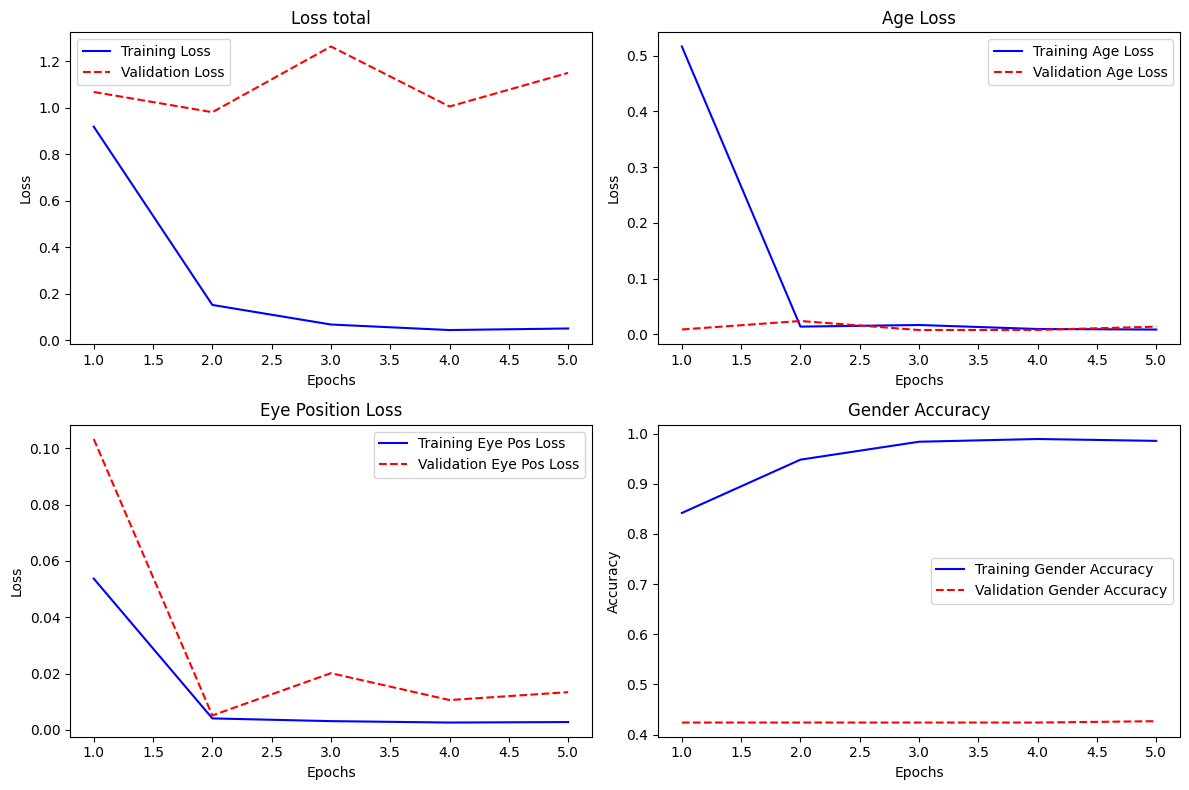

In [19]:
# Presentar grafica de metricas
plot_training_history(history)

# DATA AUGMENTATION
Ahora veremos la diferencia con los resultados en caso de aplicar data augmentation a la base de datos inicial

In [35]:
#Data augmetnation con train dataset
# Unimos el conjunto de entrenamiento en un DataFrame
train_data = pd.DataFrame({
    'im_name': images_train,
    'gender': genders_train,
    'age': ages_train,
    'left_eye_x': eyes_train['left_eye_x'].values,
    'left_eye_y': eyes_train['left_eye_y'].values,
    'right_eye_x': eyes_train['right_eye_x'].values,
    'right_eye_y': eyes_train['right_eye_y'].values
})

# Ajustar los ojos tras el flip
def flip_horizontal_and_adjust(image, eyes):
    lx, ly, rx, ry = eyes
    flipped_image = tf.image.flip_left_right(image)
    lx_, rx_ = 1 - rx, 1 - lx
    return flipped_image.numpy(), [lx_, ly, rx_, ry]


# Crear carpeta si no existe
os.makedirs('data_augmentation/images', exist_ok=True)

# Dataset aumentado (solo para training)
labels_list = []
saturation_levels = [0.7, 1.0, 1.3]

for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
    try:
        image = load_and_preprocess_image(row['im_name'])
        gender = row['gender']
        age = row['age']
        eyes = [row['left_eye_x'], row['left_eye_y'], row['right_eye_x'], row['right_eye_y']]

        for flip in [False, True]:
            img_proc = tf.identity(image)
            eyes_proc = list(eyes)

            if flip:
                img_proc, eyes_proc = flip_horizontal_and_adjust(img_proc, eyes_proc)

            for s in saturation_levels:
                img_aug = tf.image.adjust_saturation(img_proc, s)
                label = [gender, age] + eyes_proc

                name = row['im_name'].split('.')[0]
                flip_tag = "_flip" if flip else ""
                img_name = f"{name}{flip_tag}_sat{s:.1f}.jpg"
                tf.keras.utils.save_img(f"data_augmentation/images/{img_name}", img_aug.numpy())
                labels_list.append([img_name] + label)
    except Exception as e:
        print(f"Error con {row['im_name']}: {e}")

data_augmented = pd.DataFrame(labels_list, columns=['im_name', 'gender', 'age', 'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y'])


100%|██████████| 3500/3500 [00:45<00:00, 76.38it/s]


In [36]:
### Relacionar datos con imagenes para preparar el input del modelo

def load_and_preprocess_image_train(filename):
    img_path = os.path.join("data_augmentation/images/", filename)
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

# Dataset de TensorFlow que yield (imagen, etiquetas)
def tf_data_generator(images, genders, ages, eyes, is_train=True):
    for i in range(len(images)):
        if is_train:
            img = load_and_preprocess_image_train(images.iloc[i])
        else:
            img = load_and_preprocess_image(images.iloc[i])
        gender = genders.iloc[i]
        age = ages.iloc[i]
        eye_pos = eyes.iloc[i].values
        labels = {
            'gender': gender,
            'age': age,
            'eye_pos': eye_pos
        }
        yield img, labels


train_dataset = create_tf_dataset(data_augmented['im_name'], data_augmented['gender'], data_augmented['age'], data_augmented[['left_eye_x','left_eye_y', 'right_eye_x','right_eye_y']], is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image




In [37]:
#ENTRENAMOS EL MODELO

####SEMILLLAAAAA


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data_augmented['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)


Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 75s 115ms/step - age_loss: 0.0086 - age_mae: 0.0683 - eye_pos_loss: 0.0015 - eye_pos_mae: 0.0279 - gender_accuracy: 0.9030 - gender_loss: 0.2711 - loss: 0.2832 - val_age_loss: 0.0791 - val_age_mae: 0.2690 - val_eye_pos_loss: 0.0474 - val_eye_pos_mae: 0.2156 - val_gender_accuracy: 0.4239 - val_gender_loss: 4.1062 - val_loss: 4.2580
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 4:03:14 22s/step - age_loss: 0.0564 - age_mae: 0.2160 - eye_pos_loss: 0.0018 - eye_pos_mae: 0.0320 - gender_accuracy: 0.6250 - gender_loss: 1.1796 - loss: 1.2495

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - age_loss: 0.0564 - age_mae: 0.2160 - eye_pos_loss: 0.0018 - eye_pos_mae: 0.0320 - gender_accuracy: 0.6250 - gender_loss: 1.1796 - loss: 1.2495 - val_age_loss: 0.0819 - val_age_mae: 0.2740 - val_eye_pos_loss: 0.0474 - val_eye_pos_mae: 0.2154 - val_gender_accuracy: 0.4239 - val_gender_loss: 4.1838 - val_loss: 4.3391
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 76s 115ms/step - age_loss: 0.0072 - age_mae: 0.0618 - eye_pos_loss: 2.1938e-04 - eye_pos_mae: 0.0114 - gender_accuracy: 0.9732 - gender_loss: 0.0856 - loss: 0.0945 - val_age_loss: 0.0075 - val_age_mae: 0.0615 - val_eye_pos_loss: 0.0188 - val_eye_pos_mae: 0.1349 - val_gender_accuracy: 0.5761 - val_gender_loss: 0.7966 - val_loss: 0.8281
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - age_loss: 0.0433 - age_mae: 0.1978 - eye_pos_loss: 6.6427e-04 - eye_pos_mae: 0.0214 - gender_accuracy: 1.0000 - gender_loss: 0.0533 - loss: 0.1060 - val_age_loss: 0.0078 - val_age_mae: 0.0661 - val_eye_pos_los

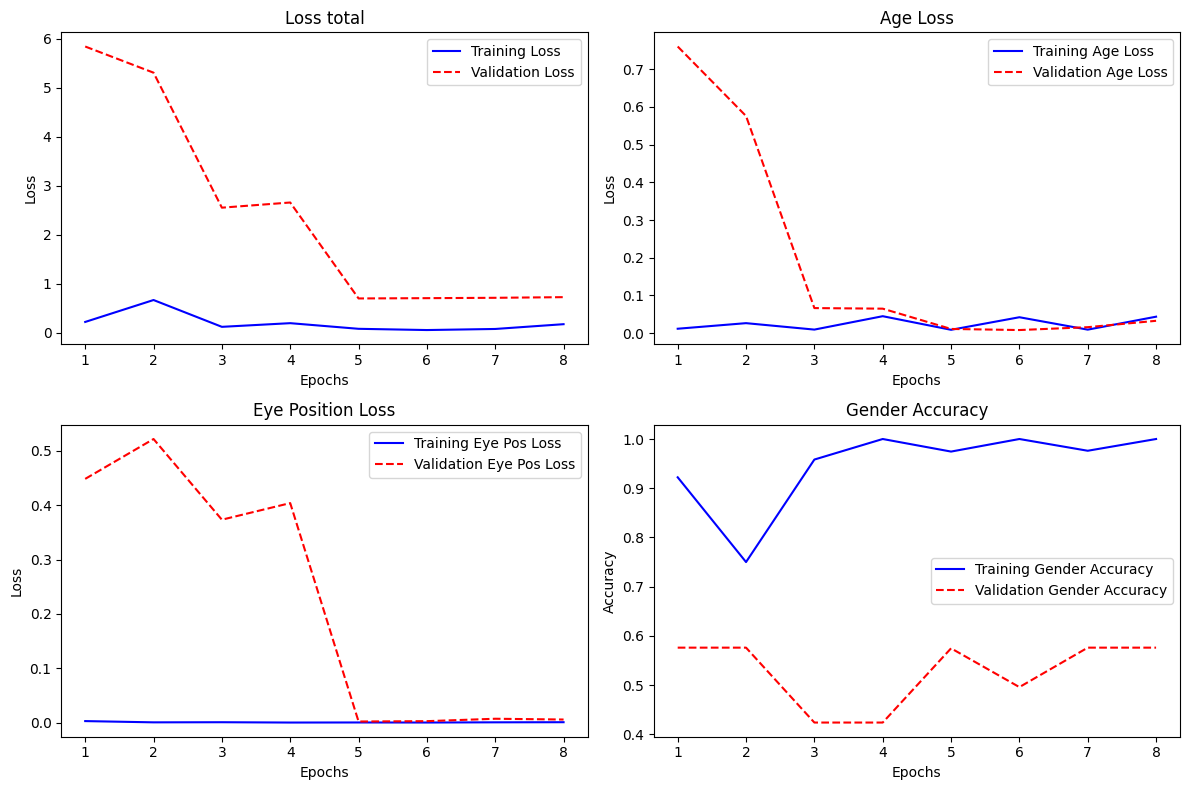

In [ ]:
# Llamar a la función para plotear las métricas
plot_training_history(history)


Como podemos ver, eye position y age mejoran con el data augmentation, pero gender empeora. Por esto vamos a dar un peso mayor a los fallos que vienen por parte de genero para que los pondere mas

In [ ]:
model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.2,
        'age': 1.0,
        'eye_pos': 1.0
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 122s 118ms/step - age_loss: 0.0110 - age_mae: 0.0763 - eye_pos_loss: 0.0020 - eye_pos_mae: 0.0248 - gender_accuracy: 0.9850 - gender_loss: 0.0457 - loss: 0.0679 - val_age_loss: 0.2494 - val_age_mae: 0.4917 - val_eye_pos_loss: 0.5670 - val_eye_pos_mae: 0.7213 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.6923 - val_loss: 2.8472
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 3:25:02 19s/step - age_loss: 0.0401 - age_mae: 0.1817 - eye_pos_loss: 5.5700e-04 - eye_pos_mae: 0.0179 - gender_accuracy: 1.0000 - gender_loss: 0.0046 - loss: 0.0462

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - age_loss: 0.0401 - age_mae: 0.1817 - eye_pos_loss: 5.5700e-04 - eye_pos_mae: 0.0179 - gender_accuracy: 1.0000 - gender_loss: 0.0046 - loss: 0.0462 - val_age_loss: 0.2844 - val_age_mae: 0.5261 - val_eye_pos_loss: 0.5625 - val_eye_pos_mae: 0.7194 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.7309 - val_loss: 2.9239
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 99s 112ms/step - age_loss: 0.0119 - age_mae: 0.0750 - eye_pos_loss: 0.0017 - eye_pos_mae: 0.0199 - gender_accuracy: 0.9823 - gender_loss: 0.0508 - loss: 0.0745 - val_age_loss: 0.5379 - val_age_mae: 0.7281 - val_eye_pos_loss: 0.3235 - val_eye_pos_mae: 0.4059 - val_gender_accuracy: 0.5761 - val_gender_loss: 0.9491 - val_loss: 2.0004
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - age_loss: 0.0571 - age_mae: 0.2272 - eye_pos_loss: 0.0011 - eye_pos_mae: 0.0298 - gender_accuracy: 1.0000 - gender_loss: 0.0186 - loss: 0.0805 - val_age_loss: 0.5842 - val_age_mae: 0.7592 - val_eye_pos_loss: 0

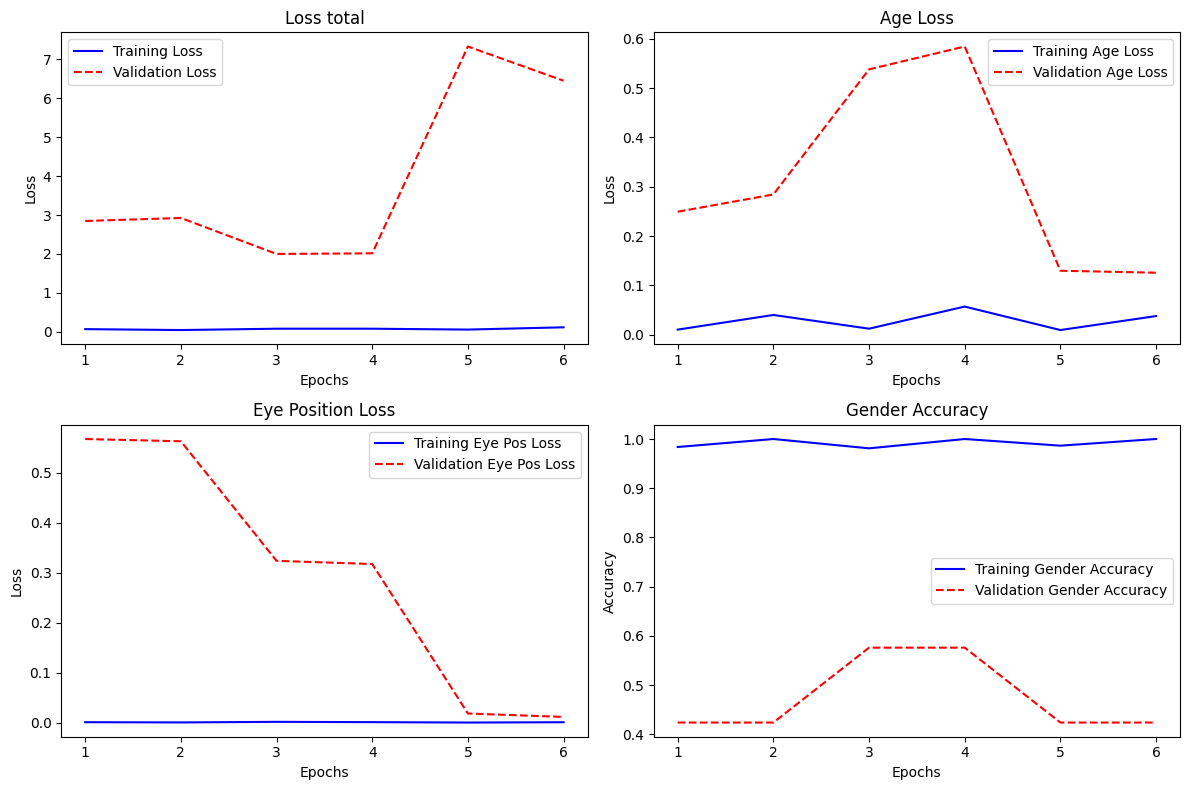

In [ ]:
# Llamar a la función para plotear las métricas
plot_training_history(history)

Resultado: ha empeorado la situación, generando un overfitting dado que el entrenamiento si que lo hace bien, pero en el caso de la validación los resultados son peores incluso

Vamos a probar a meter una cabeza densa extra en la clase del género para que tenga un pequeño submodelo y ser mas especificos en esta variable

In [23]:
# ESPECIFICACIONES DEL MODELO

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
g = Dense(64, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender')(g)

# Output 2: Age (regresión)
age_output = Dense(1, name='age')(x)

# Output 3: Eye positions (regresión 4 valores)
eye_output = Dense(4, name='eye_pos')(x)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.0,
        'eye_pos': 1.0
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)


<ipython-input-23-76b30205f57e>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [ ]:
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)


results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 123s 118ms/step - age_loss: 0.1035 - age_mae: 0.1611 - eye_pos_loss: 0.0397 - eye_pos_mae: 0.1140 - gender_accuracy: 0.8316 - gender_loss: 0.3791 - loss: 0.5224 - val_age_loss: 0.0851 - val_age_mae: 0.2796 - val_eye_pos_loss: 1.2965 - val_eye_pos_mae: 1.0984 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.0124 - val_loss: 2.3941
Epoch 2/20
  1/656 ━━━━━━━━━━━━━━━━━━━━ 3:18:09 18s/step - age_loss: 0.0392 - age_mae: 0.1935 - eye_pos_loss: 0.0066 - eye_pos_mae: 0.0685 - gender_accuracy: 0.7500 - gender_loss: 1.8032 - loss: 1.8491

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


656/656 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - age_loss: 0.0392 - age_mae: 0.1935 - eye_pos_loss: 0.0066 - eye_pos_mae: 0.0685 - gender_accuracy: 0.7500 - gender_loss: 1.8032 - loss: 1.8491 - val_age_loss: 0.1299 - val_age_mae: 0.3500 - val_eye_pos_loss: 1.2796 - val_eye_pos_mae: 1.0896 - val_gender_accuracy: 0.4239 - val_gender_loss: 1.0730 - val_loss: 2.4825
Epoch 3/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 82s 125ms/step - age_loss: 0.0091 - age_mae: 0.0725 - eye_pos_loss: 0.0024 - eye_pos_mae: 0.0377 - gender_accuracy: 0.9323 - gender_loss: 0.1815 - loss: 0.1931 - val_age_loss: 0.4981 - val_age_mae: 0.7005 - val_eye_pos_loss: 0.4293 - val_eye_pos_mae: 0.6508 - val_gender_accuracy: 0.5747 - val_gender_loss: 0.7090 - val_loss: 1.6364
Epoch 4/20
656/656 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - age_loss: 0.0191 - age_mae: 0.1352 - eye_pos_loss: 0.0048 - eye_pos_mae: 0.0593 - gender_accuracy: 0.6250 - gender_loss: 0.6742 - loss: 0.6981 - val_age_loss: 0.5040 - val_age_mae: 0.7046 - val_eye_pos_loss: 0.443

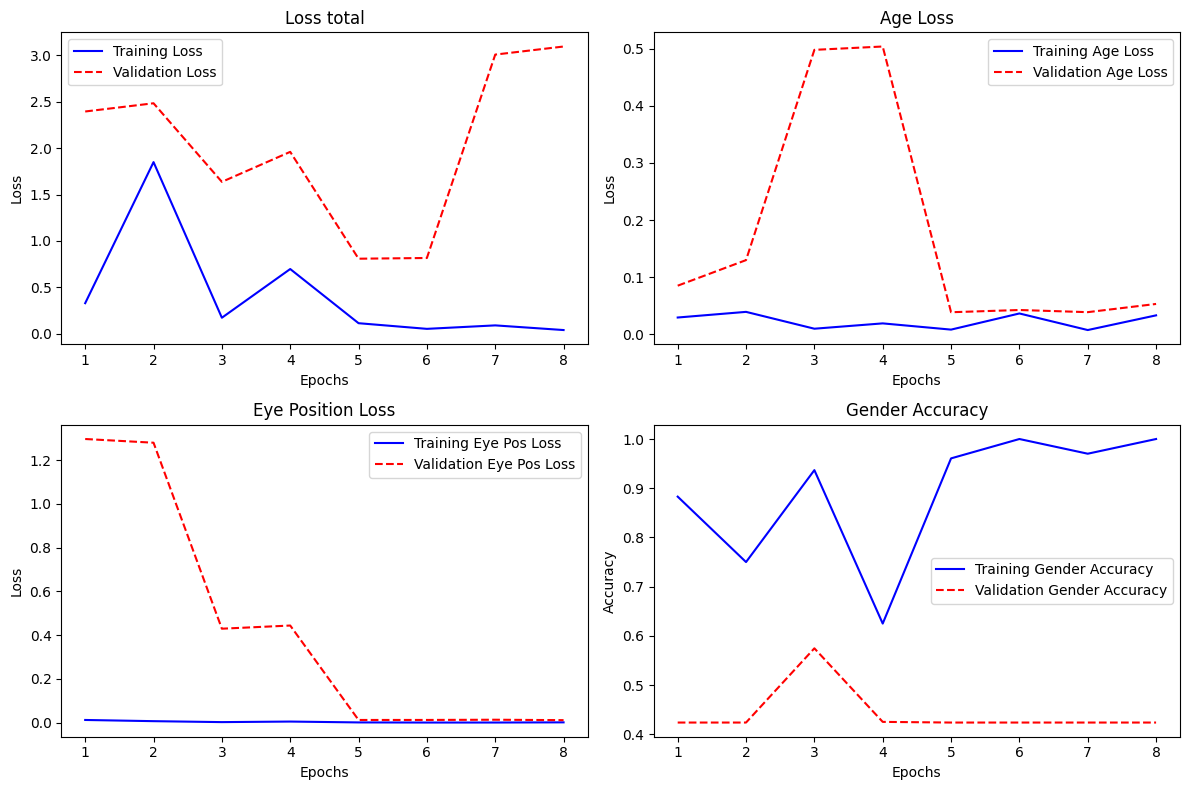

In [ ]:
# Llamar a la función para plotear las métricas
plot_training_history(history)

Como los resultados con data augmentation no han mejorado, vamos a probar los cambios en la arquitectura realizados sobre la base de datos sin aplicar data agumentation


In [21]:
train_dataset = create_tf_dataset(images_train, genders_train, ages_train, eyes_train, is_train=True)
val_dataset = create_tf_dataset(images_val, genders_val, ages_val, eyes_val, is_train=False)
test_dataset = create_tf_dataset(images_test, genders_test, ages_test, eyes_test, is_train=False)

#AÑADE BATCH Y PREFETCH PARA MEJORAR EL RENDIMIENTO

BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)



# Forzar una pequeña iteración para probar el generador
for img, label in train_dataset.take(5):
    pass  # solo itera, el print ya está en load_and_preprocess_image

In [28]:
# ESPECIFICACIONES DEL MODELO

# Input layer
input_img = Input(shape=(224, 224, 3))

# Backbone CNN preentrenada
base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Output 1: Gender (binaria)
g = Dense(64, activation='relu')(x)
gender_output = Dense(1, activation='sigmoid', name='gender')(g)

# Output 2: Age (regresión)
a = Dense(64, activation='relu')(x)
age_output = Dense(1, name='age')(a)

# Output 3: Eye positions (regresión 4 valores)
e = Dense(64, activation='relu')(x)
eye_output = Dense(4, name='eye_pos')(e)

# Modelo final
model = Model(inputs=input_img, outputs=[gender_output, age_output, eye_output])

model.compile(
    optimizer='adam',
    loss={
        'gender': 'binary_crossentropy',
        'age': 'mse',
        'eye_pos': 'mse'
    },
    loss_weights={
        'gender': 1.0,
        'age': 1.2,
        'eye_pos': 1.2
    },
    metrics={
        'gender': 'accuracy',
        'age': 'mae',
        'eye_pos': 'mae'
    }
)

<ipython-input-28-1a6f8acfa856>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_img, weights='imagenet')


In [29]:
#ENTRENAMOS EL MODELO

####SEMILLLAAAAA


callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True)
]

steps_per_epoch = len(data['im_name']) // BATCH_SIZE
validation_steps = len(images_val) // BATCH_SIZE

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=callbacks
)

test_steps = len(images_test) // BATCH_SIZE

results = model.evaluate(test_dataset, steps=test_steps)
print(results)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 89s 280ms/step - age_loss: 0.2037 - age_mae: 0.2069 - eye_pos_loss: 0.1275 - eye_pos_mae: 0.1896 - gender_accuracy: 0.8639 - gender_loss: 0.3028 - loss: 0.6998 - val_age_loss: 0.3853 - val_age_mae: 0.5247 - val_eye_pos_loss: 9.9033 - val_eye_pos_mae: 2.7522 - val_gender_accuracy: 0.8899 - val_gender_loss: 0.5047 - val_loss: 12.8510
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 23s 148ms/step - age_loss: 0.0066 - age_mae: 0.0618 - eye_pos_loss: 0.0040 - eye_pos_mae: 0.0497 - gender_accuracy: 0.9590 - gender_loss: 0.1143 - loss: 0.1270 - val_age_loss: 0.4029 - val_age_mae: 0.5083 - val_eye_pos_loss: 7.3856 - val_eye_pos_mae: 2.5192 - val_gender_accuracy: 0.9280 - val_gender_loss: 0.4707 - val_loss: 9.8169
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 22s 140ms/step - age_loss: 0.0056 - age_mae: 0.0566 - eye_pos_loss: 0.0024 - eye_pos_mae: 0.0380 - gender_accuracy: 0.9716 - gender_loss: 0.0742 - loss: 0.0839 - val_age_loss: 0.0961 - val_age_mae: 0.2048 - val_ey

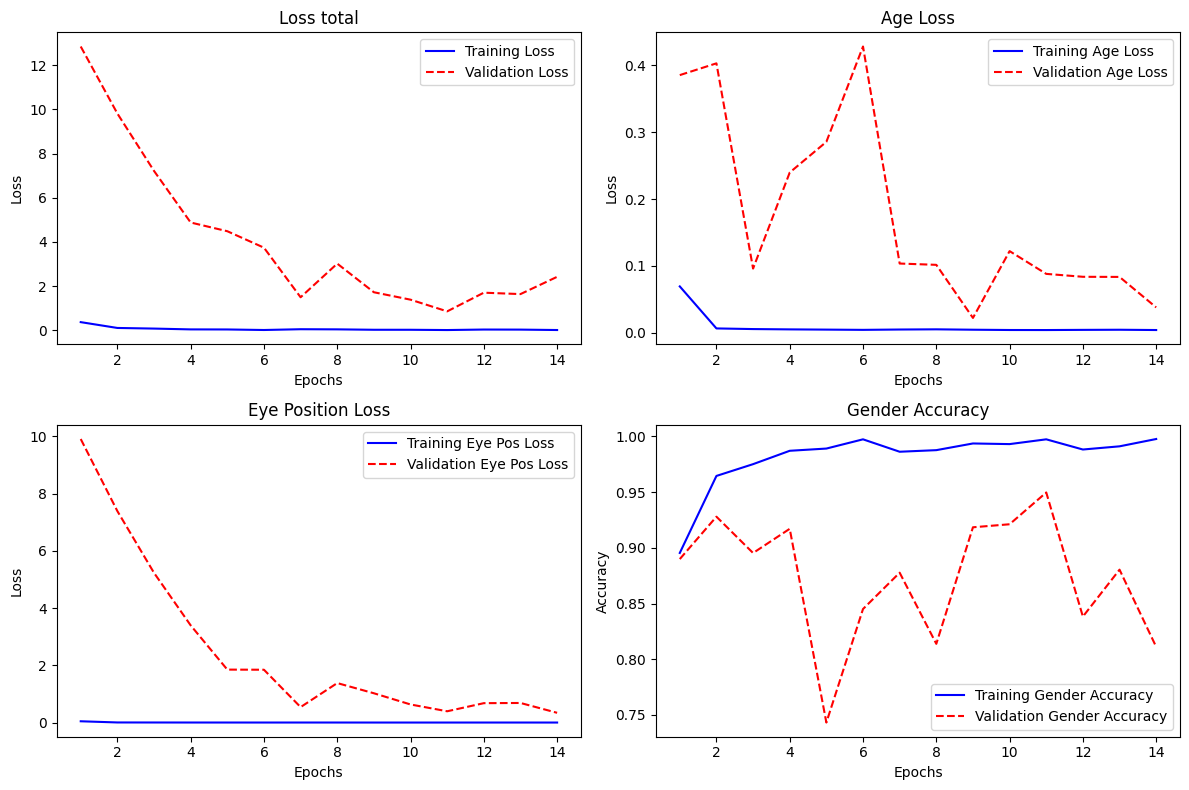

In [30]:
# Llamar a la función para plotear las métricas
plot_training_history(history)